In [3]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import plotly.express as px

# Sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# UMAP
import umap
import umap.plot

import warnings
warnings.filterwarnings("ignore")



c:\Python\Python311\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Build Dataset

In [5]:
# **Step 1: Load the Data**

# Load the data
data_all = pd.read_csv("term-deposit-marketing-2020.csv", sep=",")

# Get only subscribers
data = data_all[data_all["y"] == "yes"]
# Exclude the target variable 'y' from features
data.drop("y", axis=1, inplace=True)

# **Step 2: Data Exploration**

data.columns = [
    "age",
    "job",
    "marital",
    "education",
    "default",
    "balance",
    "housing",
    "loan",
    "contact",
    "day",
    "month",
    "duration",
    "campaign",
]

# **Step 3: Data Preprocessing**

# Identify numerical and categorical columns
numerical_cols = ["age", "balance", "day", "duration", "campaign"]
categorical_cols = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
]


# **Handle Categorical Variables**
# Convert numerical columns to numeric types
for col in numerical_cols:
    data[col] = pd.to_numeric(data[col], errors="coerce")
# Create a ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(sparse_output=False, drop="first"), categorical_cols),
    ]
)

### K-means Cluster model

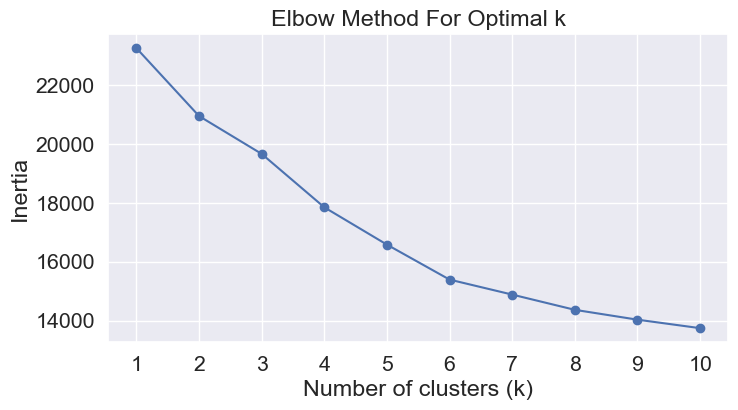

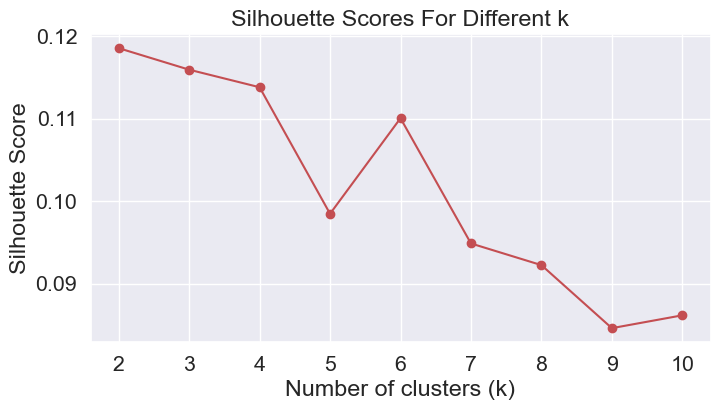

Cluster Summary (Mean Values):
               age       balance        day     duration  campaign
Cluster                                                           
0        40.337838   1028.040541  20.135135   791.141892  9.587838
1        41.655556  13509.322222  15.822222   592.733333  2.511111
2        39.260606   1117.630303  16.036364  1330.684848  2.436364
3        33.805801    986.312736   8.128625   559.712484  2.007566
4        54.877651   1608.305057  14.226754   535.649266  1.934747
5        34.068692   1203.475561  24.208719   497.383091  1.800528

Cluster Summary (Categorical Modes):
                 job  marital  education default housing loan   contact month
Cluster                                                                      
0         management  married  secondary      no      no   no  cellular   aug
1         management  married   tertiary      no      no   no  cellular   may
2        blue-collar  married  secondary      no     yes   no  cellular   may
3    

In [9]:
# **Step 4: Prepare Data for Clustering**

# Apply transformations to the data
X = preprocessor.fit_transform(data)

# **Step 5: Determine Optimal Number of Clusters**

# **Elbow Method**

inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Graph
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, "bo-")
plt.title("Elbow Method For Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_range)
plt.grid(True)
plt.show()

# **Silhouette Analysis**

silhouette_scores = []
k_range = range(2, 11)  # Silhouette score is not defined for k=1
for k in k_range:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plot the Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, "ro-")
plt.title("Silhouette Scores For Different k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_range)
plt.grid(True)
plt.show()

# **Step 6: Apply K-Means with Optimal k**

# Based on the above methods, choose the optimal k
# Let's assume the optimal k is 3 (you can decide based on the plots)
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, init="k-means++", random_state=42)
labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# **Add Cluster Labels to the DataFrame**

data["Cluster"] = labels

# **Step 7: Analyze the Clusters**

# Compute the mean of numerical features for each cluster
cluster_summary = data.groupby("Cluster")[numerical_cols].mean()
print("Cluster Summary (Mean Values):")
print(cluster_summary)

# **Optional: Analyze Categorical Features**

# For each cluster, compute the mode of categorical features
categorical_summary = data.groupby("Cluster")[categorical_cols].agg(
    lambda x: x.mode().iloc[0]
)
print("\nCluster Summary (Categorical Modes):")
print(categorical_summary)

### PCA

#### 2 components

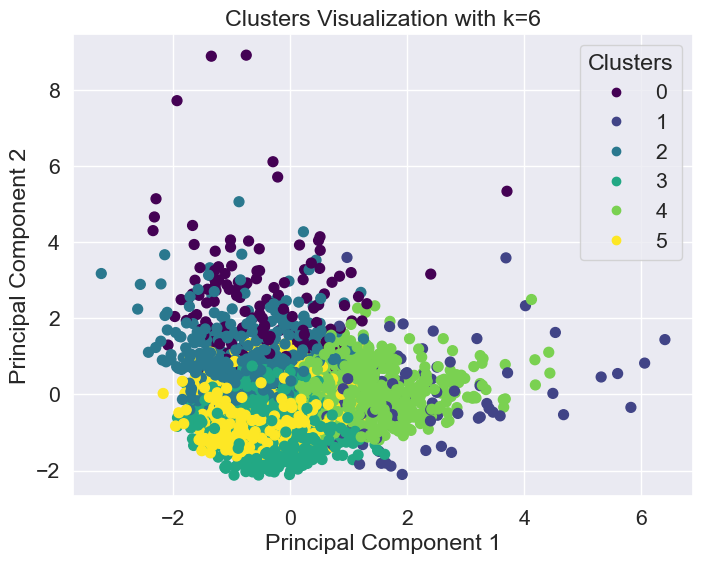

In [25]:
# **Optional: Visualize Clusters in 2D (Using PCA)**

from sklearn.decomposition import PCA

# Reduce data to two dimensions for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

# Plot the clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    c=labels,
    cmap="viridis",
    s=50,
)
plt.title(f"Clusters Visualization with k={optimal_k}")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

#### 3 components

In [22]:
# PCA using 3 components
pca = PCA(n_components=3)
components = pca.fit_transform(X)

# 3D scatterplot
fig = px.scatter_3d(
    components,
    x=0,
    y=1,
    z=2,
    color=labels,
    size=0.1 * np.ones(len(X)),
    opacity=1,
    title="PCA plot in 3D",
    labels={"0": "PC 1", "1": "PC 2", "2": "PC 3"},
    width=850,
    height=500,
)
fig.show()

#### Explaining variance graph

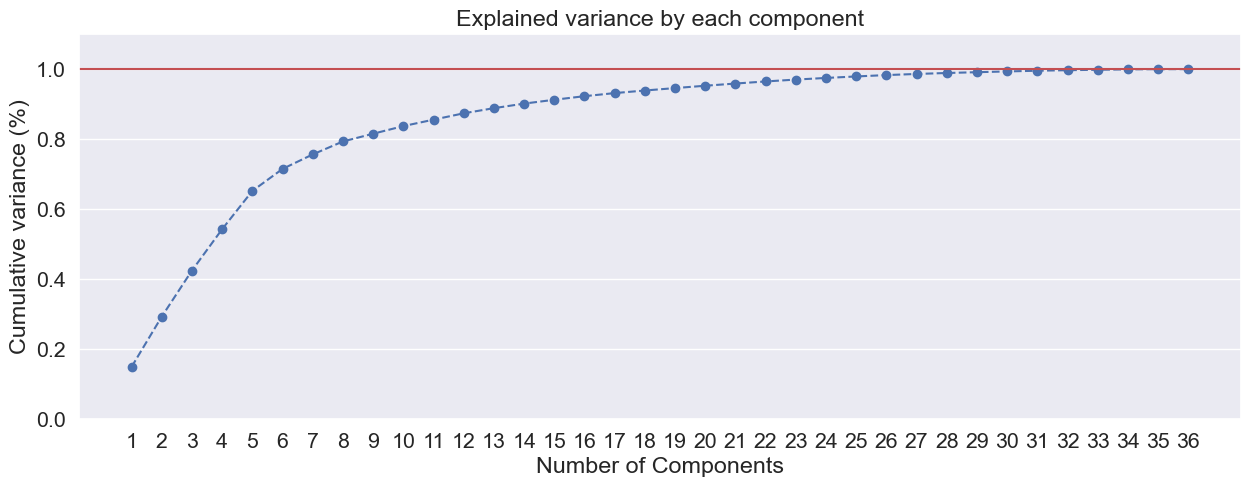

In [23]:
# PCA
pca_var = PCA()
pca_var.fit(X)

# Plot
plt.figure(figsize=(15, 5))
xi = np.arange(1, 1 + X.shape[1], step=1)
yi = np.cumsum(pca_var.explained_variance_ratio_)
plt.plot(xi, yi, marker="o", linestyle="--", color="b")

# Aesthetics
plt.ylim(0.0, 1.1)
plt.xlabel("Number of Components")
plt.xticks(np.arange(1, 1 + X.shape[1], step=1))
plt.ylabel("Cumulative variance (%)")
plt.title("Explained variance by each component")
plt.axhline(y=1, color="r", linestyle="-")
plt.gca().xaxis.grid(False)

### t-SNE

Use perplexity as hyperparameter

In [26]:
# t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# Convert to data frame
tsne_df = pd.DataFrame(data=X_tsne, columns=["tsne 1", "tsne 2"])

# Shape and preview
print(tsne_df.shape)
tsne_df.head()

(2896, 2)


,tsne 1,tsne 2
0,-6.198428,26.796673
1,-6.153140,27.883963
2,-16.396812,7.190079
3,-8.016468,27.449240
4,11.185143,31.893835


#### 2 components

Text(0, 0.5, 'tsne component 2')

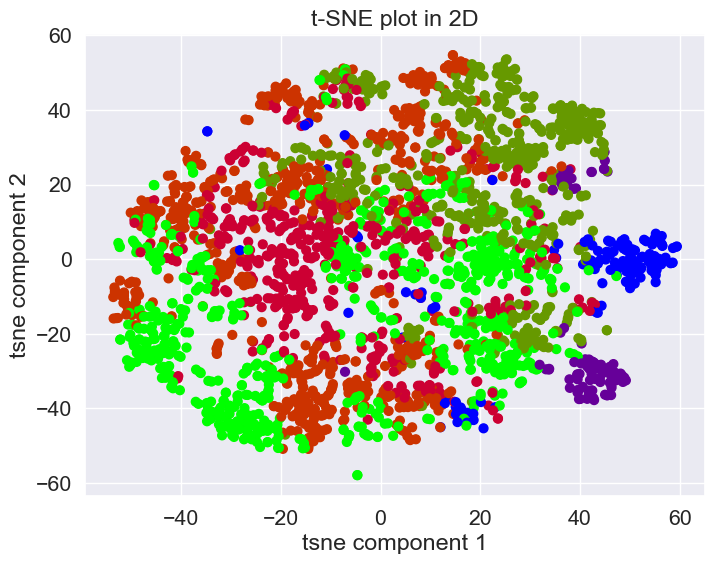

In [27]:
# Figure size
plt.figure(figsize=(8, 6))

# Scatterplot
plt.scatter(tsne_df.iloc[:, 0], tsne_df.iloc[:, 1], c=labels, cmap="brg", s=40)

# Aesthetics
plt.title("t-SNE plot in 2D")
plt.xlabel("tsne component 1")
plt.ylabel("tsne component 2")

#### 3 components

In [30]:
# t-SNE
tsne = TSNE(n_components=3)
components_tsne = tsne.fit_transform(X)

# 3D scatterplot
fig = px.scatter_3d(
    components_tsne,
    x=0,
    y=1,
    z=2,
    color=labels,
    size=0.1 * np.ones(len(X)),
    opacity=1,
    title="t-SNE plot in 3D",
    labels={"0": "tsne 1", "1": "tsne 2", "2": "tsne 3"},
    width=850,
    height=500,
)
fig.show()

### UMAP

Use Neighbors as hyperparameter

In [6]:
# UMAP
um = umap.UMAP()
X_fit = um.fit(X)  # we'll use X_fit later
X_umap = um.transform(X)

# Convert to data frame
umap_df = pd.DataFrame(data=X_umap, columns=["umap comp. 1", "umap comp. 2"])

# Shape and preview
print(umap_df.shape)
umap_df.head()

(2896, 2)


,umap comp. 1,umap comp. 2
0,8.641173,10.864539
1,8.675103,10.892248
2,8.865244,10.187227
3,8.454144,10.685387
4,5.394684,6.484489


#### 2 components

Text(0, 0.5, 'umap component 2')

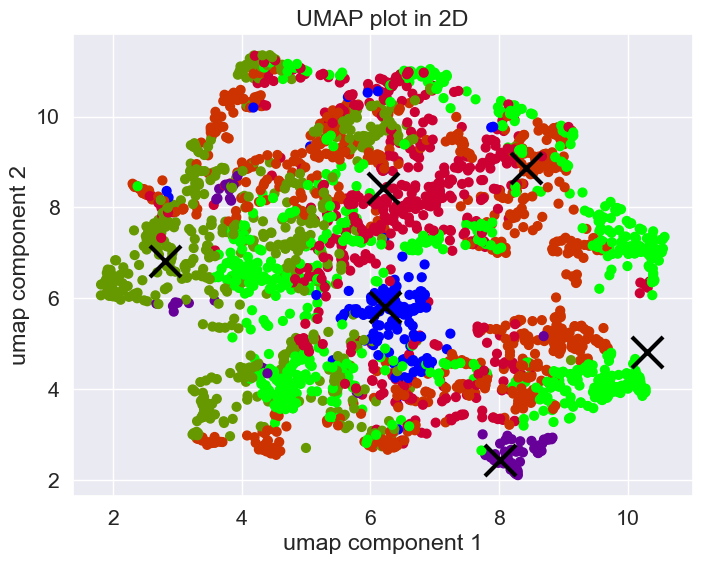

In [33]:
# Figure size
plt.figure(figsize=(8, 6))

# Scatterplot
plt.scatter(umap_df.iloc[:, 0], umap_df.iloc[:, 1], c=labels, cmap="brg", s=40)

# Centroids
centroids_umap = um.transform(centroids)
plt.scatter(
    x=centroids_umap[:, 0],
    y=centroids_umap[:, 1],
    marker="x",
    s=500,
    linewidths=3,
    color="black",
)

# Aesthetics
plt.title("UMAP plot in 2D")
plt.xlabel("umap component 1")
plt.ylabel("umap component 2")

#### 3 components

In [35]:
# UMAP
um = umap.UMAP(n_components=3)
components_umap = um.fit_transform(X)

# 3D scatterplot
fig = px.scatter_3d(
    components_umap,
    x=0,
    y=1,
    z=2,
    color=labels,
    size=0.1 * np.ones(len(X)),
    opacity=1,
    title="UMAP plot in 3D",
    labels={"0": "comp. 1", "1": "comp. 2", "2": "comp. 3"},
    width=850,
    height=500,
)
fig.show()

In [9]:
def draw_umap(
    n_neighbors=15, min_dist=0.1, n_components=2, metric="euclidean", title=""
):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
    )
    u = fit.fit_transform(X)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:, 0], range(len(u)), c=labels)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:, 0], u[:, 1], c=labels)
    if n_components == 3:
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(u[:, 0], u[:, 1], u[:, 2], c=labels, s=100)
    plt.title(title, fontsize=18)

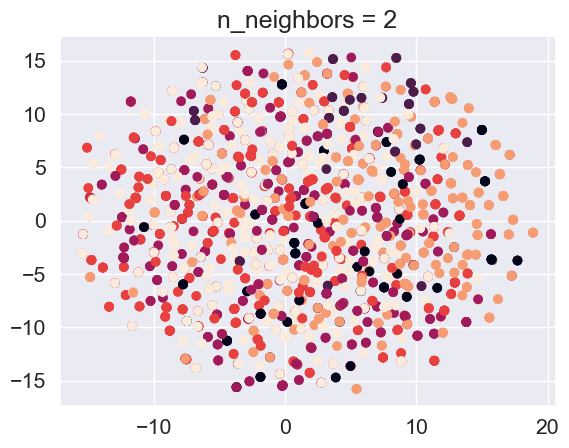

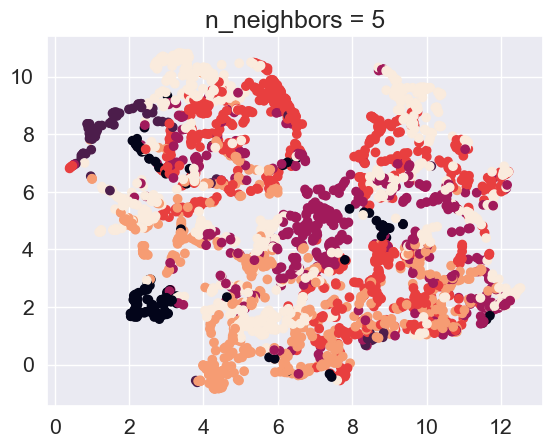

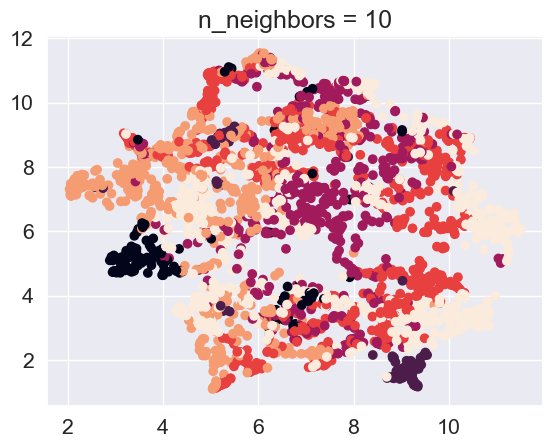

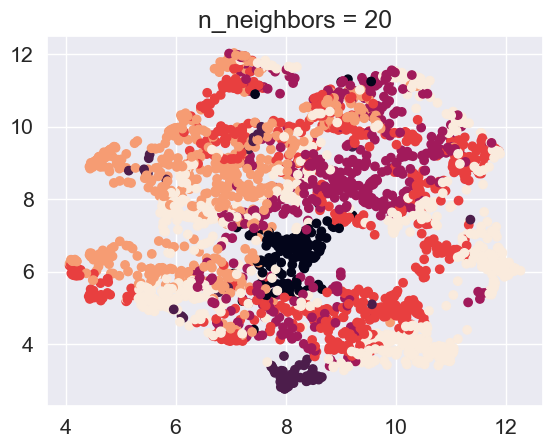

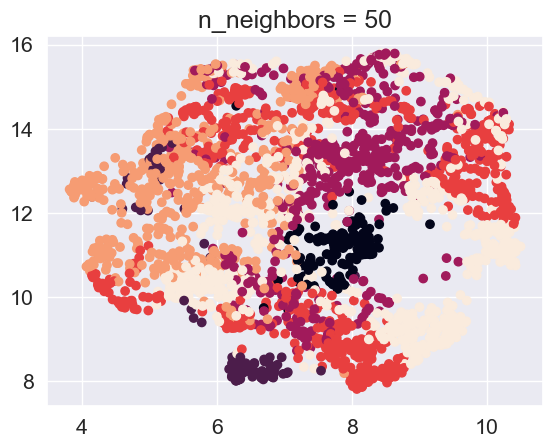

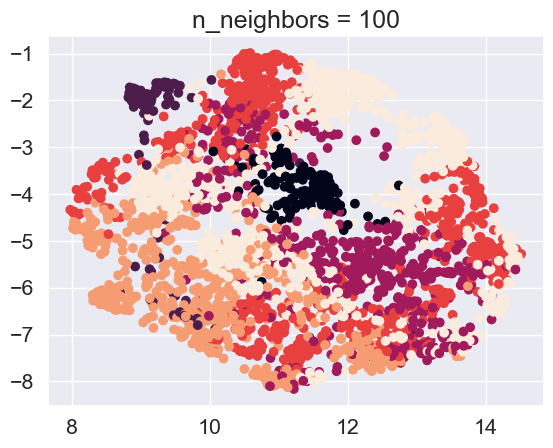

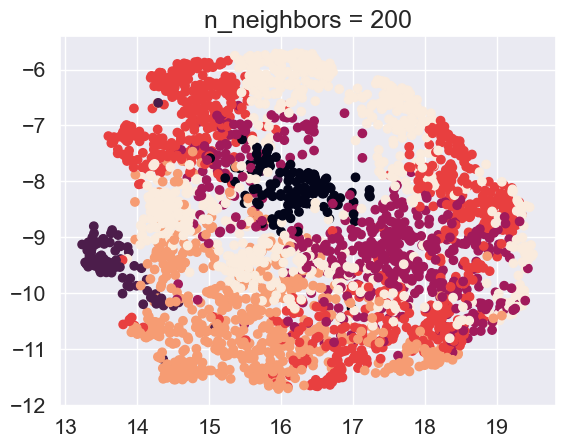

In [10]:
for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title="n_neighbors = {}".format(n))

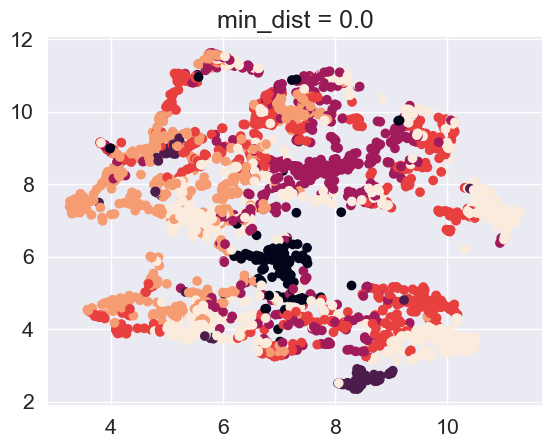

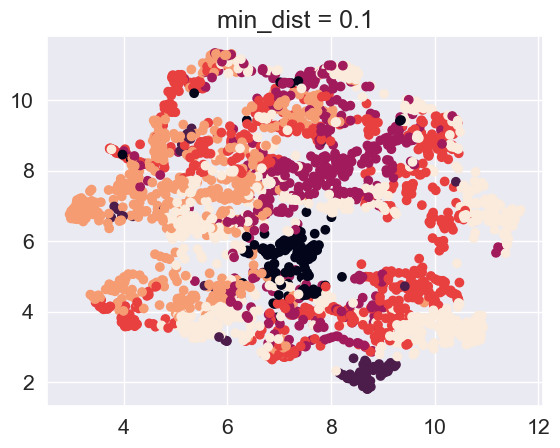

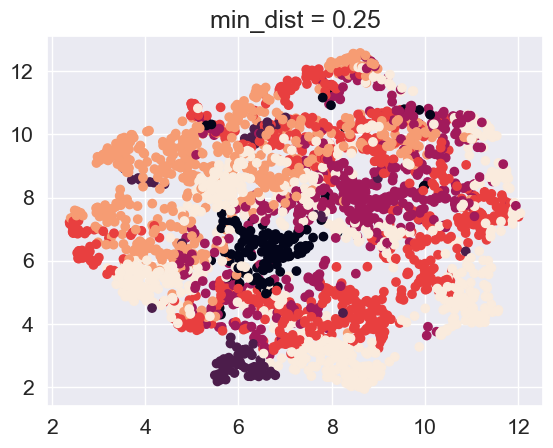

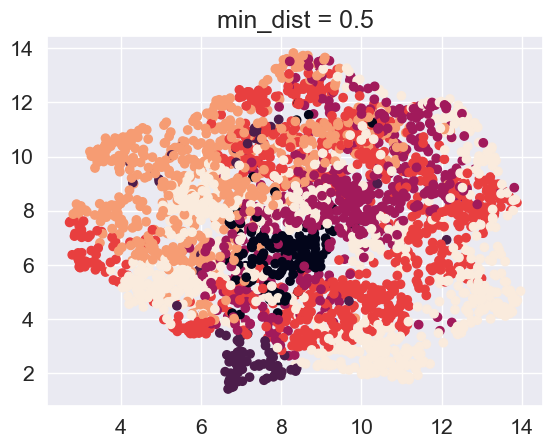

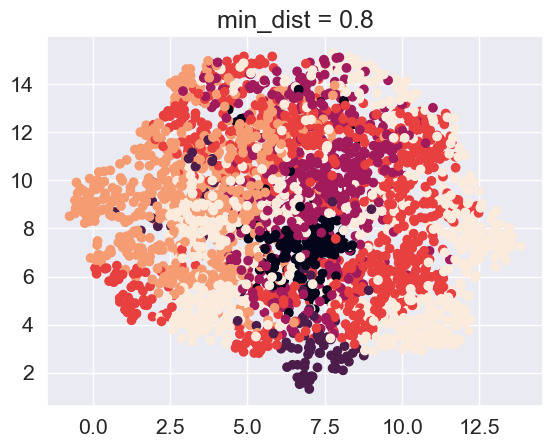

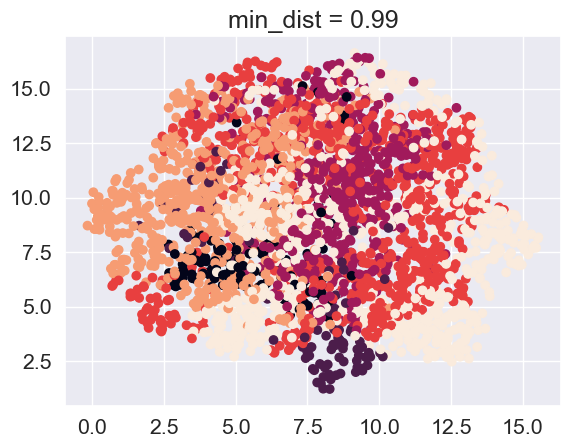

In [11]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title="min_dist = {}".format(d))